# Simple Use of pipelines

In [14]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix

import missingno as msno
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,12)

import seaborn as sns

%matplotlib inline

In [2]:
np.random.seed(1)

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [3]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
398,2.0,"Drew, Master. Marshall Brines",male,8.0,0.0,2.0,28220,32.5000,None,S
1307,3.0,"Zakarian, Mr. Ortin",male,27.0,0.0,0.0,2670,7.2250,None,C
309,1.0,"Wick, Miss. Mary Natalie",female,31.0,0.0,2.0,36928,164.8667,C7,S
1301,3.0,"Youseff, Mr. Gerious",male,45.5,0.0,0.0,2628,7.2250,None,C
1048,3.0,"Nakid, Miss. Maria ('Mary')",female,1.0,0.0,2.0,2653,15.7417,None,C


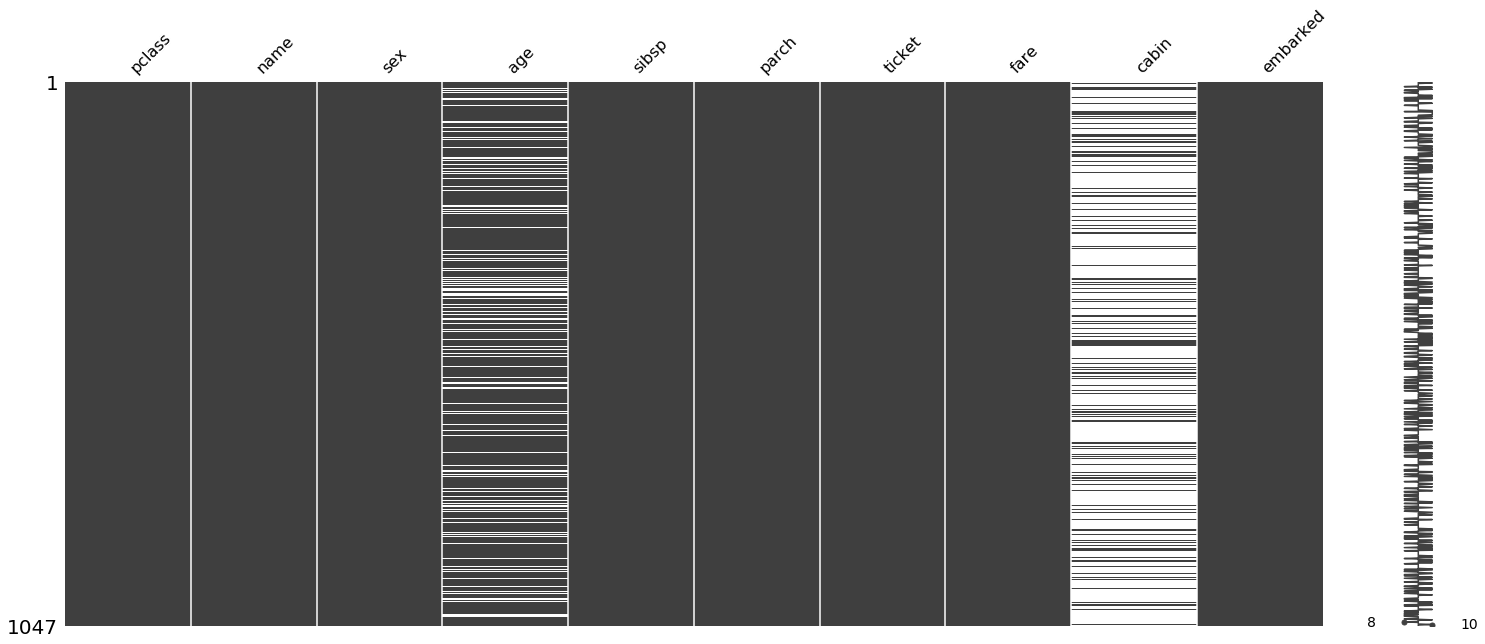

In [4]:
msno.matrix(X_train)
plt.show()

In [5]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.961796
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       77.077364
embarked     0.095511
dtype: float64

### Let's do some minimal tranformation

In [6]:
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

C:\Users\Adrien\Anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 1, 'Corr')

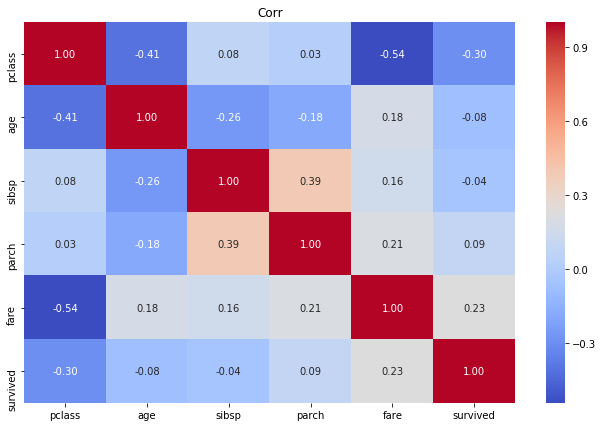

In [16]:
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)

fig, heat = plt.subplots(figsize = (11,7))
heat = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "coolwarm",
                fmt= ',.2f' )

heat.set_title("Corr")

In [17]:
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['parch'] + dataset['sibsp']
    dataset.drop(['parch', 'sibsp'], axis=1, inplace=True)
    dataset['is_alone'] = 1
    dataset['is_alone'].loc[dataset['family_size'] > 1] = 0

X_train.head()

C:\Users\Adrien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Adrien\Anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Adrien\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,pclass,name,sex,age,ticket,fare,embarked,family_size,is_alone
398,2.0,"Drew, Master. Marshall Brines",male,8.0,28220,32.5000,S,2.0,0
1307,3.0,"Zakarian, Mr. Ortin",male,27.0,2670,7.2250,C,0.0,1
309,1.0,"Wick, Miss. Mary Natalie",female,31.0,36928,164.8667,S,2.0,0
1301,3.0,"Youseff, Mr. Gerious",male,45.5,2628,7.2250,C,0.0,1
1048,3.0,"Nakid, Miss. Maria ('Mary')",female,1.0,2653,15.7417,C,2.0,0


In [18]:
for dataset in [X_train, X_test]:
    dataset['title'] =  dataset['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset.drop(["name"], axis=1, inplace=True)

X_train.head()

C:\Users\Adrien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pclass,sex,age,ticket,fare,embarked,family_size,is_alone,title
398,2.0,male,8.0,28220,32.5000,S,2.0,0,Master
1307,3.0,male,27.0,2670,7.2250,C,0.0,1,Mr
309,1.0,female,31.0,36928,164.8667,S,2.0,0,Miss
1301,3.0,male,45.5,2628,7.2250,C,0.0,1,Mr
1048,3.0,female,1.0,2653,15.7417,C,2.0,0,Miss


In [19]:
pd.crosstab(X_train['title'], X_train['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Lady,1,0
Major,0,1
Master,0,52
Miss,210,0


In [20]:
print(f"Miss: {np.sum(y_train.astype(int)[X_train.title == 'Miss']) / len(X_train.title == 'Miss')}")
print(f"Mrs: {np.sum(y_train.astype(int)[X_train.title == 'Mrs']) / len(X_train.title == 'Mrs')}")

Miss: 0.1356255969436485
Mrs: 0.11365807067812798


In [21]:
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

Mr              False
Miss            False
Mrs             False
Master          False
Rev              True
Dr               True
Col              True
Major            True
Ms               True
Mlle             True
Sir              True
Capt             True
Dona             True
the Countess     True
Jonkheer         True
Mme              True
Lady             True
Don              True
Name: title, dtype: bool

In [22]:
for dataset in [X_train, X_test]:
    dataset.title.loc[dataset.title == 'Miss'] = 'Mrs'
    dataset['title'] = dataset.title.apply(lambda x: 'rare' if rare_titles[x] else x)

C:\Users\Adrien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Adrien\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
for dataset in [X_train, X_test]:
    dataset.drop('ticket', axis=1, inplace=True)

X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,title
398,2.0,male,8.0,32.5000,S,2.0,0,Master
1307,3.0,male,27.0,7.2250,C,0.0,1,Mr
309,1.0,female,31.0,164.8667,S,2.0,0,Mrs
1301,3.0,male,45.5,7.2250,C,0.0,1,Mr
1048,3.0,female,1.0,15.7417,C,2.0,0,Mrs


In [24]:
X_train.dtypes

pclass          float64
sex            category
age             float64
fare            float64
embarked       category
family_size     float64
is_alone          int64
title            object
dtype: object

In [25]:
cat_cols = ['embarked', 'sex', 'pclass', 'title', 'is_alone']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(n_components=10))
])

In [26]:
cat_transformer[0]

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [27]:
num_cols = ['age', 'fare', 'family_size']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [29]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7831897926634769

In [30]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 15))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100)

#### We don't care about good results, do let's go for Random search instead of Grid search

In [31]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                KNNImputer(add_indicator=False,
                                                                                     

In [32]:
random_search.best_score_

0.8099111414900889

In [33]:
y_pred = random_search.predict(X_test)
y_pred[:5]

array(['0', '1', '0', '1', '0'], dtype=object)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       162
           1       0.83      0.69      0.75       100

    accuracy                           0.83       262
   macro avg       0.83      0.80      0.81       262
weighted avg       0.83      0.83      0.82       262



#### Overall accuracy looks ok, but is it evenly true for both death / survivals ?

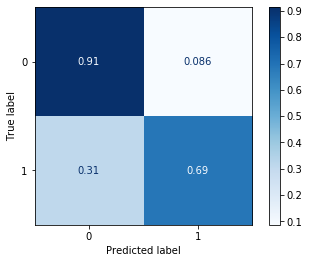

In [36]:
plot_confusion_matrix(random_search, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show()

#### Good to predict those who died, not that good for predicting who actually managed to survive